In [1]:
# Importo las librerías Necesarias 
import numpy as np # Importo algebra Lineal
import matplotlib.pyplot as plt # Importo librería de gráficos
import math
import gmsh #Importo gmsh
from scipy import linalg
plt.rc('figure', figsize=(10,5))   # Para gráficos
plt.rc('font', size=15)             # Para gráficos

### Desarrollo

#### Armo modelo

In [2]:
gmsh.initialize() # Inicio el gmsh

In [3]:
gmsh.model.add('Final') # Nombro el modelo

In [4]:
#Datos

L = 0.1 #m
rmax = 0.032 #m
rmin = 0.025 #m
pestaña = 0.003 #m
Conduc = 187.25 #W/m°C Conductividad
Cesp = 477 #J/kg°C  Calor especifico
Densidad = 7850 #kg/m^3  Densidad del acero
Espesor = 0.0001 #m
Tprob = 900 #°C Temperatura de la probeta a la salida del horno
Ttemple = 25 #°C Temperatura del agua de temple

#Densidad de triangulos en el modelo
lc = 0.002 #0.001

In [5]:
# Definimos las coordenadas de los puntos

p1 = gmsh.model.geo.addPoint(       0,      0, 0, lc)
p2 = gmsh.model.geo.addPoint(       0, rmax/2, 0, lc)
p3 = gmsh.model.geo.addPoint( pestaña, rmax/2, 0, lc)
p4 = gmsh.model.geo.addPoint( pestaña, rmin/2, 0, lc)
p5 = gmsh.model.geo.addPoint(       L, rmin/2, 0, lc)
p6 = gmsh.model.geo.addPoint(       L,      0, 0, lc)

In [6]:
# Definimos las lineas

l1 = gmsh.model.geo.addLine(p1, p2)
l2 = gmsh.model.geo.addLine(p2, p3)
l3 = gmsh.model.geo.addLine(p3, p4)
l4 = gmsh.model.geo.addLine(p4, p5)
l5 = gmsh.model.geo.addLine(p5, p6)
l6 = gmsh.model.geo.addLine(p6, p1)

In [7]:
# Las curvas nos van a servir para definir los bordes de nuestro modelo
C1 = gmsh.model.geo.addCurveLoop([l1, l2, l3, l4, l5, l6])

# y la superficie
S1 = gmsh.model.geo.addPlaneSurface([C1])

In [8]:
gmsh.model.geo.synchronize()

In [9]:
# Defino los grupos fisicos
Templado=gmsh.model.addPhysicalGroup(1,[l5])
gmsh.model.setPhysicalName(1, Templado, 'Templado')

Superficie = gmsh.model.addPhysicalGroup(2,[S1])
gmsh.model.setPhysicalName(2,Superficie, 'Superficie')
gmsh.model.mesh.generate(2)

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 40%] Meshing curve 3 (Line)
Info    : [ 50%] Meshing curve 4 (Line)
Info    : [ 70%] Meshing curve 5 (Line)
Info    : [ 90%] Meshing curve 6 (Line)
Info    : Done meshing 1D (Wall 0.000447699s, CPU 0s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0110636s, CPU 0.030966s)
Info    : 460 nodes 924 elements


In [10]:
# Generamos el mallado
gmsh.model.mesh.generate(2) # el 2 indica la dimensión

Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0078082s, CPU 0.008456s)
Info    : 460 nodes 924 elements


In [11]:
# Vista del mallado
gmsh.fltk.run()

-------------------------------------------------------
Version       : 4.10.5
License       : GNU General Public License
Build OS      : Linux64-sdk
Build date    : 20220701
Build host    : gmsh.info
Build options : 64Bit ALGLIB[contrib] ANN[contrib] Bamg Blas[petsc] Blossom Cgns DIntegration Dlopen DomHex Eigen[contrib] Fltk Gmm[contrib] Hxt Jpeg Kbipack Lapack[petsc] LinuxJoystick MathEx[contrib] Med Mesh Metis[contrib] Mmg Mpeg Netgen ONELAB ONELABMetamodel OpenCASCADE OpenCASCADE-CAF OpenGL OpenMP OptHom PETSc Parser Plugins Png Post QuadMeshingTools QuadTri Solver TetGen/BR Voro++[contrib] WinslowUntangler Zlib
FLTK version  : 1.4.0
PETSc version : 3.14.4 (real arithmtic)
OCC version   : 7.6.1
MED version   : 4.1.0
Packaged by   : geuzaine
Web site      : https://gmsh.info
Issue tracker : https://gitlab.onelab.info/gmsh/gmsh/issues
-------------------------------------------------------


#### Selección de datos

In [12]:
# Obtengo información sobre los nodos del mallado

NodeInfo = gmsh.model.mesh.get_nodes() # Información de los nodos
n_nodos = NodeInfo[0].shape[0] # Cantidad de nodos
MN = NodeInfo[1].reshape(n_nodos, 3) # Matriz de nodos (con eje Z)

In [13]:
# Obtengo información sobre los elementos del mallado

E_etiq, Elementos = gmsh.model.mesh.get_elements_by_type(2) #El 2 es por elementos del tipo 2 (superficiales)
n_element = E_etiq.shape[0] # Cantidad de elementos
n_nxe = 3 #Número de nodos por elemento
MC = Elementos.reshape(n_element, n_nxe) # Matriz de conectividad
MC = MC - np.ones([n_element, n_nxe]) # Resto 1 para acomodar a lenguaje PYTHON.
MC = MC.astype(int) # Los cambio a dato tipo integer

#### Armado de matrices

In [14]:
Ke = np.zeros((n_nxe, n_nxe)) # Matriz de rigidez elemental
Kg = np.zeros([len(MN), len(MN)]) # Matriz de rigidez global
Ce = np.array([[2, 1, 1], # Matriz de capacitancia elemental
               [1, 2, 1],
               [1, 1, 2]]) 
Cg = np.zeros([len(MN), len(MN)]) # Matriz de capacitancia global
for i in range(len(MC)):
    
    # Calculo matriz A
    Xi = MN[MC[i, 0], 0]
    Yi = MN[MC[i, 0], 1]
    Xj = MN[MC[i, 1], 0]
    Yj = MN[MC[i, 1], 1]
    Xk = MN[MC[i, 2], 0]
    Yk = MN[MC[i, 2], 1]
    A = np.abs((1/2)*np.linalg.det([[1, Xi, Yi],
                                    [1, Xj, Yj],
                                    [1, Xk, Yk]]))
    
    # Calculo Ke
    Ke[0, 0] = (Yj-Yk)**2 + (Xk-Xj)**2
    Ke[1, 1] = (Yk-Yi)**2 + (Xi-Xk)**2
    Ke[2, 2] = (Yi-Yj)**2 + (Xj-Xi)**2
    Ke[0, 1] = (Yj-Yk)*(Yk-Yi) + (Xk-Xj)*(Xi-Xk)
    Ke[1, 0] = Ke[0, 1] # Por simetria
    Ke[0, 2] = (Yj-Yk)*(Yi-Yj)+(Xk-Xj)*(Xj-Xi)
    Ke[2, 0] = Ke[0, 2] # Por simetria
    Ke[1, 2] = (Yk-Yi)*(Yi-Yj)+(Xi-Xk)*(Xj-Xi)
    Ke[2, 1] = Ke[1, 2] # Por simetria

    Ke = (Conduc*Espesor)/(4*A)*Ke

    # Calculo Kg y Cg
    n, m, l = MC[i, :]
    aux = np.array([n, m, l]) # Indices
    Kg[np.ix_(aux, aux)] += Ke
    Cg[np.ix_(aux, aux)] += (1/6)*Ce*Cesp*Densidad*Espesor*A

#### Condiciones de contorno

In [15]:
n_Templado = gmsh.model.mesh.get_nodes_for_physical_group(1,Templado)
S = n_Templado[0].astype(int)-1 # Los nodos en el extremo templano tendran una T fija
R = np.array([i for i in range(n_nodos) if i not in S]) # Complemento de S

#### Solución

In [16]:
from tqdm.auto import tqdm

In [17]:
To = np.zeros((len(MN),1)) # To contendra las temperaturas iniciales de todos los nodos
To[S] = Ttemple # Los nodos del extremo templado tendran una T fija igual a la de temple
To[R] = Tprob # El resto de los nodos empezara con una T igual al de la probeta salida del horno
tmax = 10# 250 #600 # Tiempo maximo a evaluar mdfcomment: no puedo esperar tanto, tengo sueño.
dt = 0.005 # Tiempo entre calculos
n = int(tmax/dt)
MT = np.zeros((n,len(MN)))   # Matriz de temperaturas de todos los nodos a lo largo del tiempo
MT[0, :] = To.reshape(1, -1)
progress = tqdm(range(n-1))
for i in progress: #range(n-1):
    # Calculo la teperatura para el siguiente tiempo
    aux = np.dot(Kg[np.ix_(R, R)], To[R])+np.dot(Kg[np.ix_(R, S)], To[S])
    Tnext = To[R]-dt*(np.dot(np.linalg.inv(Cg[np.ix_(R, R)]), aux))
    
    # Completo en la matriz de temperaturas
    MT[i+1, [S]] = To[S].reshape(1, -1)
    MT[i+1, [R]] = Tnext.reshape(1, -1)
    
    # Mi nuevo To sera la ultima temperatura calculada para cada nodo
    To = MT[i+1, :]

  0%|          | 0/1999 [00:00<?, ?it/s]

#### Grafico la evolución de la temperatura para ciertas distancias de la probeta

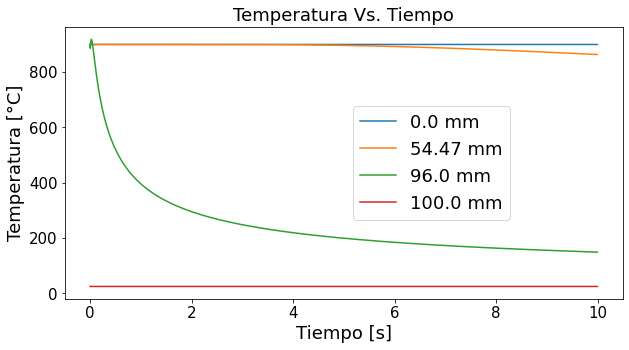

In [18]:
#Son Distancias de referencia en los extremos y centro de la probeta
T1=MT[:,0]
T2=MT[:,40]
T3=MT[:,70]
T4=MT[:,4]
t=np.arange(len(T1))*dt

plt.ion()
plt.plot(t, T1, t, T2, t, T3, t, T4)
plt.title("Temperatura Vs. Tiempo",fontsize=18)
plt.xlabel("Tiempo [s]",fontsize=18)   
plt.ylabel("Temperatura [°C]",fontsize=18) 
plt.legend([str(round(MN[0][0]*1000, 2))+' mm', str(round(MN[40][0]*1000,2))+' mm', str(round(MN[70][0]*1000,2))+' mm', str(round(MN[4][0]*1000,2))+' mm'],bbox_to_anchor=(0.5, 0.5), loc='best',fontsize=18)


#### Vista en gmsh

In [19]:
from tqdm.auto import tqdm

In [20]:
# Calculo la temperatura de cada elemento a lo largo del tiempo
MET = np.zeros([len(MT[:, 0]), n_element]) # Matriz de T de los elementos a lo largo del tiempo
progress = tqdm(range(len(MT[:,0])))
for i in progress: #range(len(MT[:, 0])): # Como tengo la T en los nodos, calculo un aproximado de la T de los elementos promediando
    for j in range(n_element):
        n, m, l = MC[j, :]
        MET[i, j] = (MT[i, n]+MT[i, m]+MT[i, l])/3

  0%|          | 0/2000 [00:00<?, ?it/s]

<div style="background:#999900">y ahora para cada t, tenes que guardar un view con el t correspondiente,</div>

In [21]:
# Grafico la distribución de la temperatura para el tiempo deseado (indicarlo en el número de fila de la matriz MET)
#temp = gmsh.view.add('Temperatura (°C)')
TEMPE = []
tempe = gmsh.view.add('Temperatura (°C) (Elementos)')
progress = tqdm(enumerate(MET), total=len(MET))
for i, TE in progress:
    TEMPE.append(
        gmsh.view.addModelData(tempe, i, 'Final', 'ElementData', E_etiq, TE.reshape([-1,1]), time=dt*i, numComponents=1)
        )



  0%|          | 0/2000 [00:00<?, ?it/s]

<div style="background:#999900"> pero el resultado que tenes es por nodo !</div>

In [22]:
TEMPN = []

In [23]:
tempn = gmsh.view.add('Temperatura (°C) (nodos)')
progress = tqdm(enumerate(MT), total=len(MT))
for i, T in progress:
    TEMPN.append(
        gmsh.view.addModelData(tempn, i, 'Final', 'NodeData', NodeInfo[0], T.reshape([-1, 1]), time = dt*i, numComponents=1) 
    )

  0%|          | 0/2000 [00:00<?, ?it/s]

In [24]:
#Actualizo y grafico
gmsh.model.geo.synchronize()
gmsh.view.write(tempn, 'temperaturasnodales.msh')
gmsh.view.write(tempe, 'temperaturasnodales.msh')

In [40]:
gmsh.fltk.run()

-------------------------------------------------------
Version       : 4.10.5
License       : GNU General Public License
Build OS      : Linux64-sdk
Build date    : 20220701
Build host    : gmsh.info
Build options : 64Bit ALGLIB[contrib] ANN[contrib] Bamg Blas[petsc] Blossom Cgns DIntegration Dlopen DomHex Eigen[contrib] Fltk Gmm[contrib] Hxt Jpeg Kbipack Lapack[petsc] LinuxJoystick MathEx[contrib] Med Mesh Metis[contrib] Mmg Mpeg Netgen ONELAB ONELABMetamodel OpenCASCADE OpenCASCADE-CAF OpenGL OpenMP OptHom PETSc Parser Plugins Png Post QuadMeshingTools QuadTri Solver TetGen/BR Voro++[contrib] WinslowUntangler Zlib
FLTK version  : 1.4.0
PETSc version : 3.14.4 (real arithmtic)
OCC version   : 7.6.1
MED version   : 4.1.0
Packaged by   : geuzaine
Web site      : https://gmsh.info
Issue tracker : https://gitlab.onelab.info/gmsh/gmsh/issues
-------------------------------------------------------


Error   : Unknown output file format


Info    : Writing '.msh'...
Info    : Done writing '.msh'


In [31]:
gmsh.view.write(tempn, 'temperaturasnodales.html')

Info    : Writing 'temperaturasnodales.gif'...
Info    : Done writing 'temperaturasnodales.gif'


##### Imagenes del gmsh para diferentes tiempos

Distribución de temperatura en la probeta a los $ 0.1 segundos $
<center><img src="Probeta_0.1s.png"></center>

Distribución de temperatura en la probeta a los $ 0.5 segundos $
<center><img src="Probeta_0.5s.png"></center>

Distribución de temperatura en la probeta a los $ 1 segundos $
<center><img src="Probeta_1s.png"></center>

Distribución de temperatura en la probeta a los $ 2 segundos $
<center><img src="Probeta_2.5s.png"></center>

Distribución de temperatura en la probeta a los $ 5 segundos $
<center><img src="Probeta_5s.png"></center>

Distribución de temperatura en la probeta a los $ 10 segundos $
<center><img src="Probeta_10s.png"></center>

Distribución de temperatura en la probeta a los $ 25 segundos $
<center><img src="Probeta_25s.png"></center>

Distribución de temperatura en la probeta a los $ 50 segundos $
<center><img src="Probeta_50s.png"></center>

Distribución de temperatura en la probeta a los $ 100 segundos $
<center><img src="Probeta_100s.png"></center>

Distribución de temperatura en la probeta a los $ 200 segundos $
<center><img src="Probeta_200s.png"></center>

Distribución de temperatura en la probeta a los $ 400 segundos $
<center><img src="Probeta_400s.png"></center>

Distribución de temperatura en la probeta a los $ 600 segundos $
<center><img src="Probeta_600s.png"></center>